In [1]:
from pathlib import Path
import sys
import polars as pl

# veure-ho tot → plot_pitch_with_flat_regions
# una svara concreta + context → plot_svara_window_with_flat_regions
# experimentar a mà → _add_flat_regions_to_ax

In [2]:
def find_project_root(start=None):
    if start is None:
        start = Path.cwd().resolve()
    for p in [start] + list(start.parents):
        if (p / "data").exists():
            return p
    return start


PROJECT_ROOT = find_project_root()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
import settings as S

In [4]:
recording_id = S.CURRENT_PIECE

flat_path = (
    S.DATA_INTERIM
    / recording_id
    / "flat_regions"
    / f"{recording_id}_flat_regions.parquet"
)

flat_path


PosixPath('/home/lluis/master-thesis/CSISD/data/interim/srs_v1_bdn_sav/flat_regions/srs_v1_bdn_sav_flat_regions.parquet')

In [5]:
df = pl.read_parquet(flat_path)

df.head()


f0_Hz,f0_pchip,f0_pchip_cents,time_rel_sec,f0_savgol_p3_w13,f0_savgol_p3_w13_cents,flat_candidate,flat_region,flat_id
f32,f32,f32,f32,f32,f32,bool,bool,i32
0.0,NaN,NaN,0.0,NaN,NaN,false,false,null
0.0,NaN,NaN,0.010001,NaN,NaN,false,false,null
0.0,NaN,NaN,0.020001,NaN,NaN,false,false,null
0.0,NaN,NaN,0.030002,NaN,NaN,false,false,null
0.0,NaN,NaN,0.040003,NaN,NaN,false,false,null


In [6]:
df.columns

['f0_Hz',
 'f0_pchip',
 'f0_pchip_cents',
 'time_rel_sec',
 'f0_savgol_p3_w13',
 'f0_savgol_p3_w13_cents',
 'flat_candidate',
 'flat_region',
 'flat_id']

In [7]:
# Prioritat: cents si existeix
candidate_pitch_cols = [
    f"{S.PITCH_COL}_cents",
    S.PITCH_COL_CENTS,
    S.PITCH_COL,          # fallback
]

pitch_col = next((c for c in candidate_pitch_cols if c in df.columns), None)
pitch_col


'f0_savgol_p3_w13_cents'

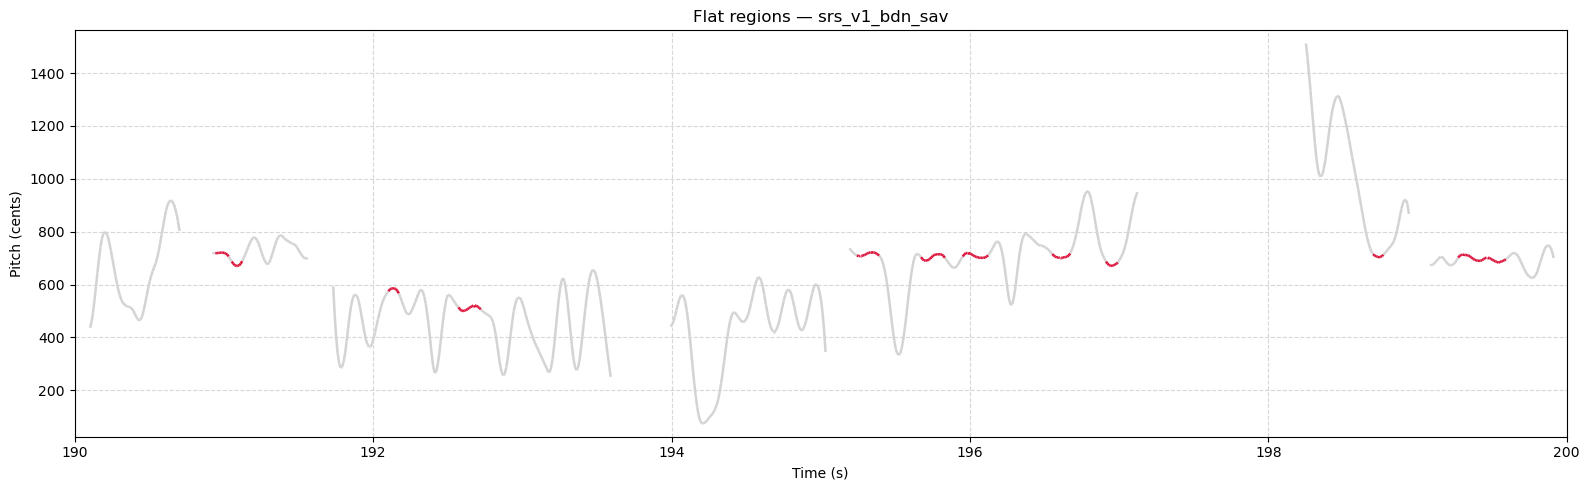

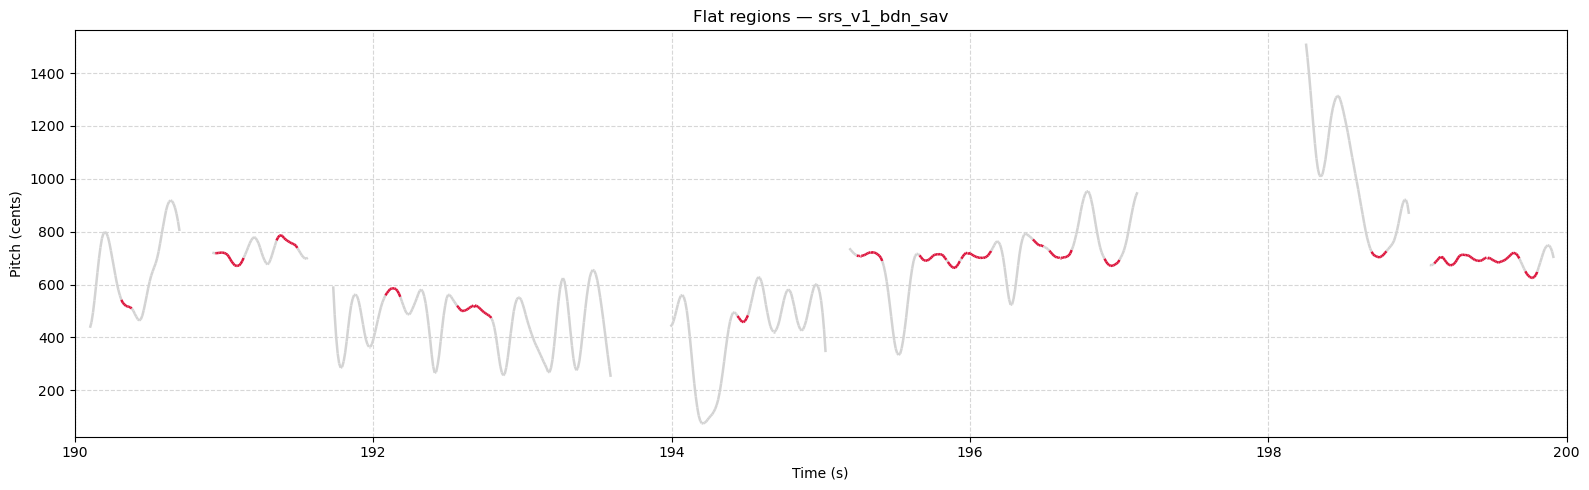

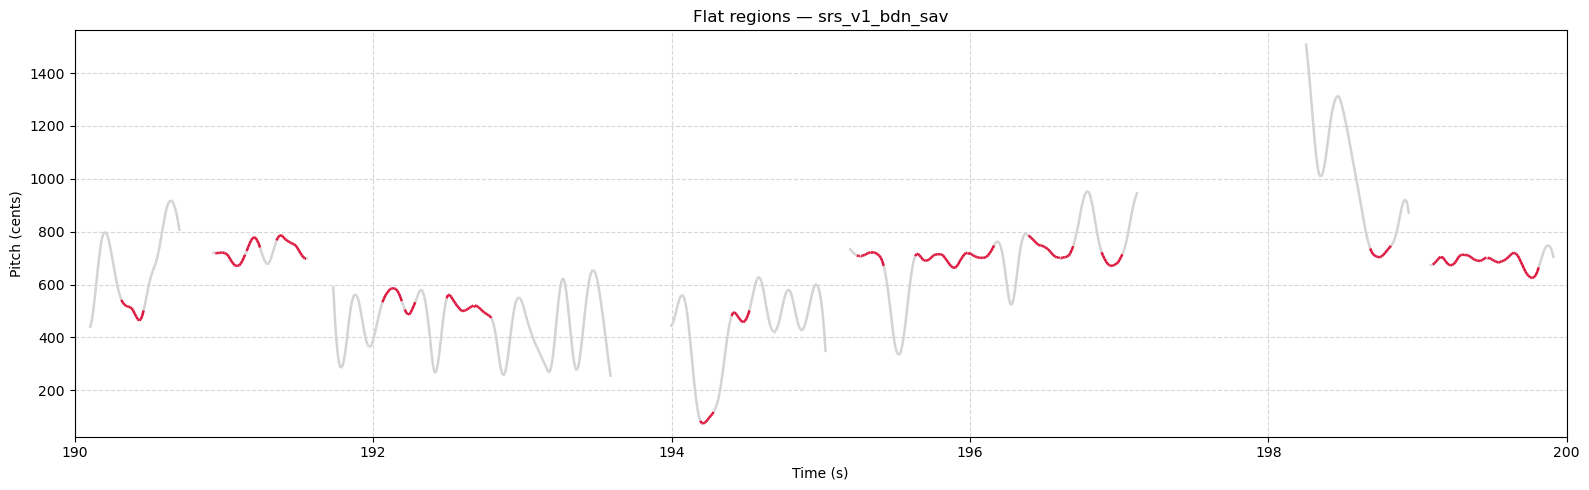

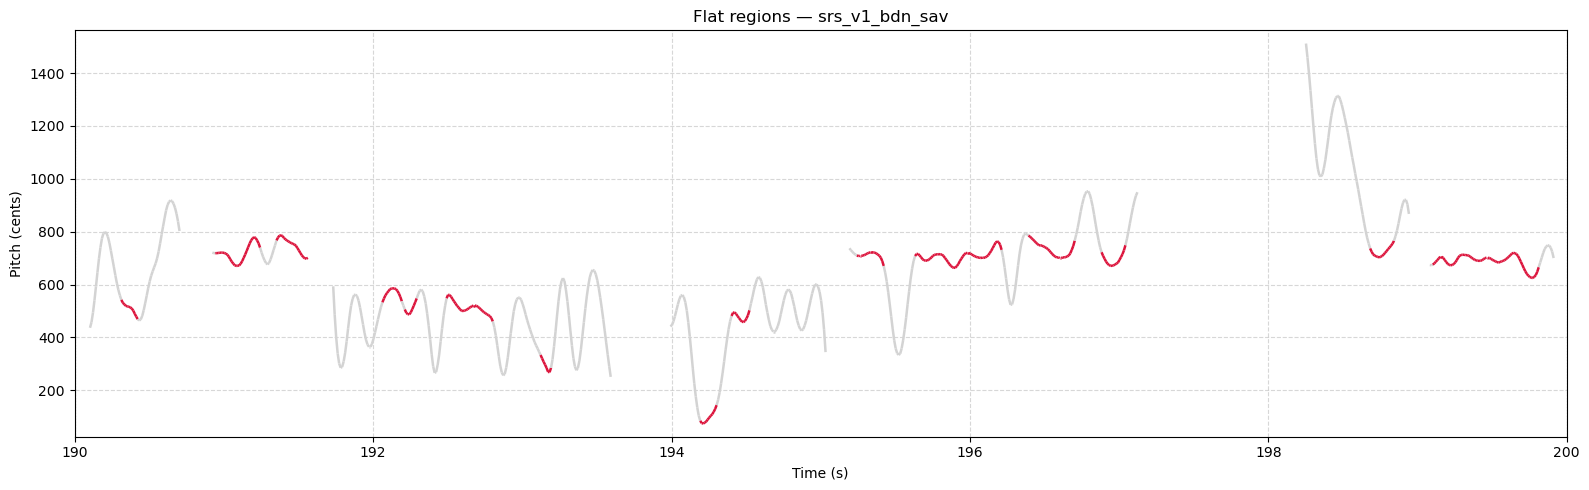

In [8]:
from src.utils.plot import plot_pitch_with_flat_regions
from src.features.flatness import extract_flat_regions
from src.io.pitch_io import load_preprocessed_pitch
from src.io.annotation_io import load_annotations
from src.annotations.svara import attach_svara_annotations_to_pitch

t_min = float(df.select(pl.col(S.TIME_COL).min()).item())
t0 = t_min + 190.0
t1 = t0 + 10.0

recording_id = S.CURRENT_PIECE
TOLERANCE_CENTS_LIST = [5, 10, 20, 30]
d1_threshold = 1500.0
TONIC = S.SARASUDA_TONICS[S.CURRENT_PIECE]
ann_path = S.DATA_CORPUS / recording_id / "raw" / f"{recording_id}_ann_svara.tsv"

for tolerance_cents in TOLERANCE_CENTS_LIST:
    
    df = load_preprocessed_pitch(
        recording_id=recording_id,
        root_dir=S.DATA_INTERIM,
        tonic_hz=TONIC,
        convert_to_cents=True,
    )
    df_svaras = load_annotations(
        file_path=ann_path,
        annotation_type="svara",

    )

    df = attach_svara_annotations_to_pitch(df, df_svaras) 

    df = extract_flat_regions(
        df,
        time_col=S.TIME_COL,
        pitch_col=pitch_col,
        pitch_unit="cents",
        candidate_col=S.CANDIDATE_COL,   # si no existeix, es crearà dins la funció
        out_col=S.STABLE_COL,
        min_duration_sec=S.MIN_STABLE_DURATION_SEC,
        cent_tolerance=tolerance_cents,
        d1_threshold=d1_threshold,
        abs_deriv1_col=getattr(S, "ABS_DERIV1_COL", None),  # opcional per debug
        verbose=False,
    )

    plot_pitch_with_flat_regions(
        df,
        time_col=S.TIME_COL,
        pitch_col=pitch_col,
        stable_col=S.STABLE_COL,
        time_range=(t0, t1),
        title=f"Flat regions — {recording_id}",
        pitch_unit="cents" if pitch_col.endswith("_cents") else "hz",
    )


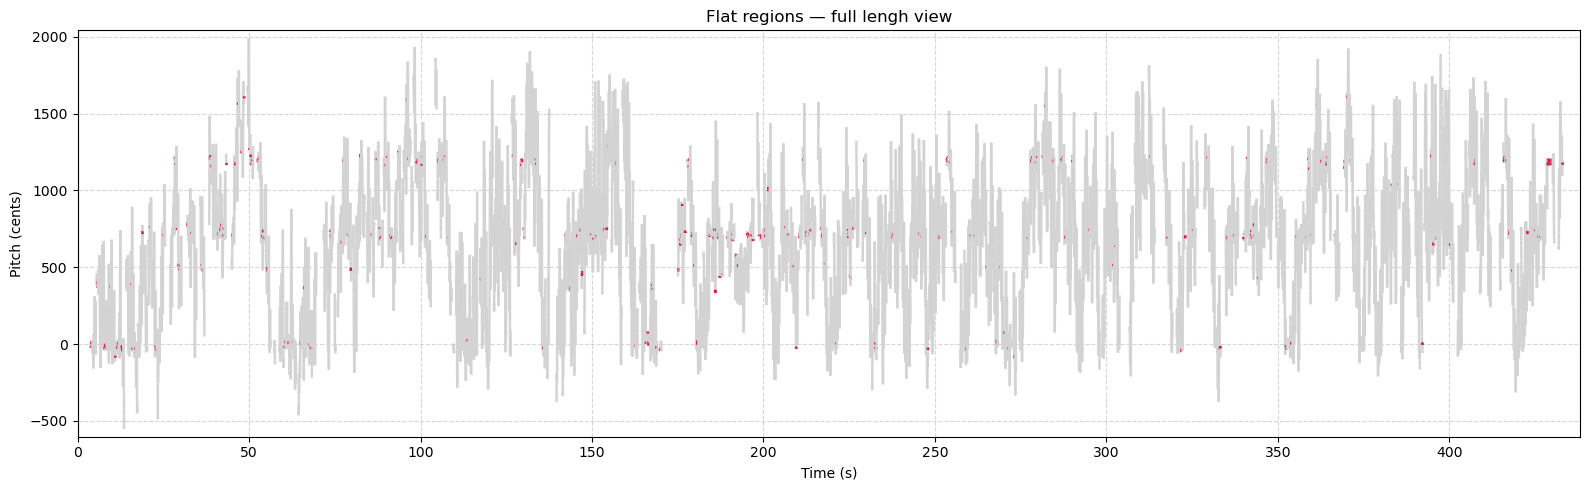

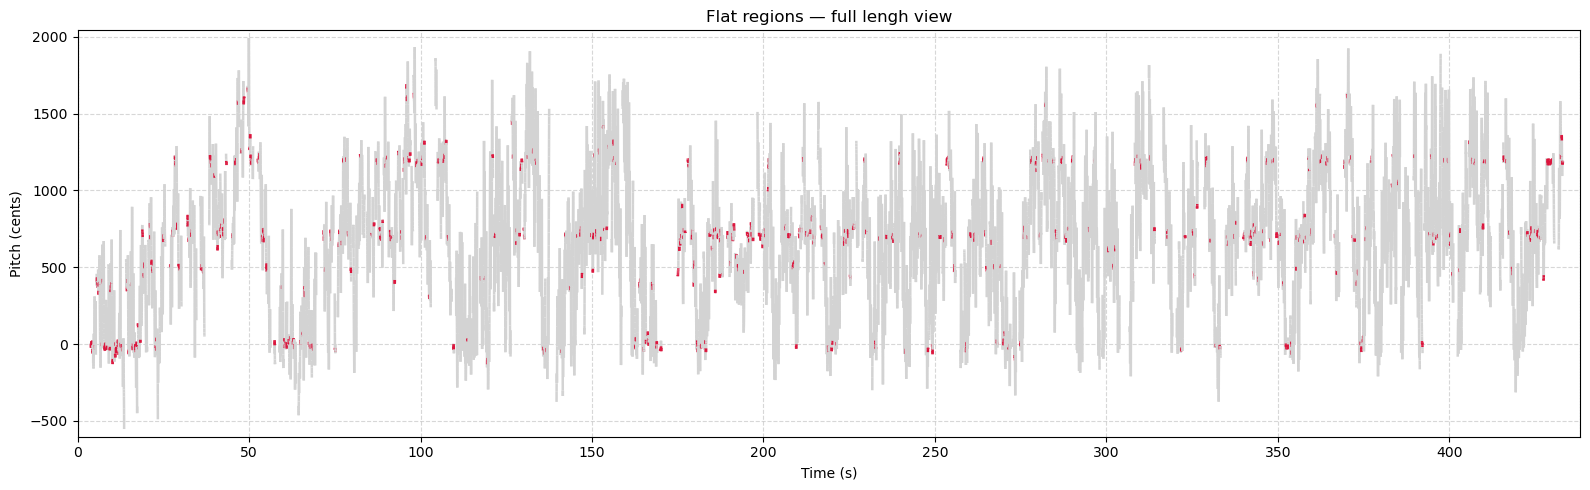

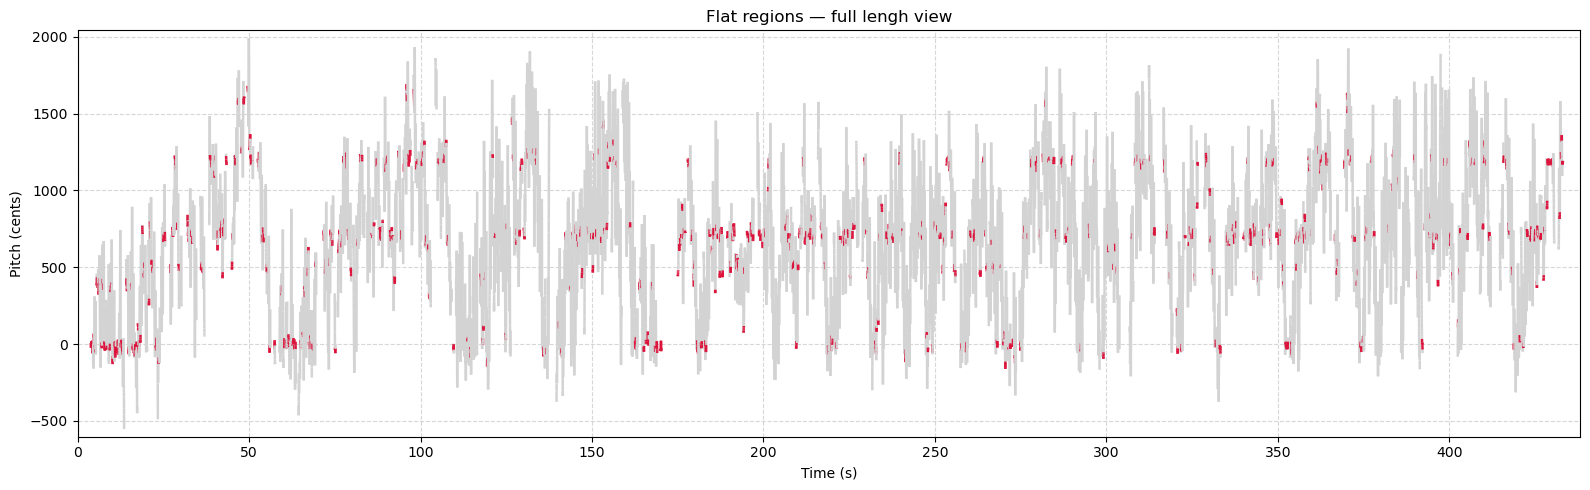

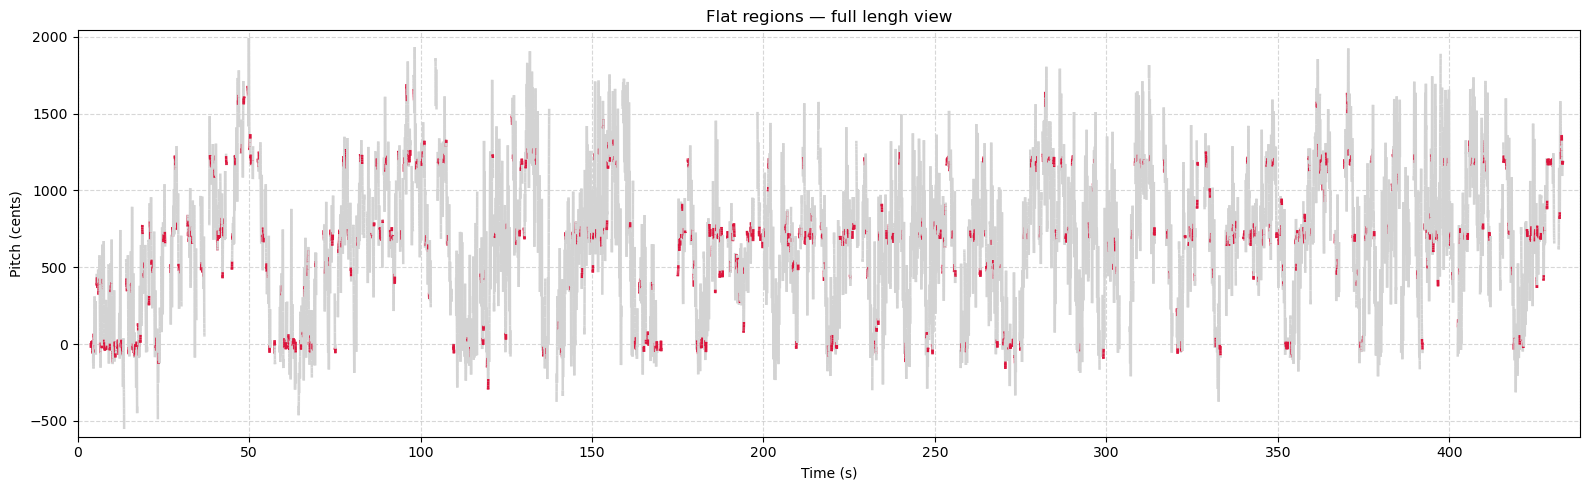

In [9]:
from src.utils.plot import plot_pitch_with_flat_regions

for tolerance_cents in TOLERANCE_CENTS_LIST:
    
    df = load_preprocessed_pitch(
        recording_id=recording_id,
        root_dir=S.DATA_INTERIM,
        tonic_hz=TONIC,
        convert_to_cents=True,
    )
    
    df = extract_flat_regions(
        df,
        time_col=S.TIME_COL,
        pitch_col=pitch_col,
        pitch_unit="cents",
        candidate_col=S.CANDIDATE_COL,   # si no existeix, es crearà dins la funció
        out_col=S.STABLE_COL,
        min_duration_sec=S.MIN_STABLE_DURATION_SEC,
        cent_tolerance=tolerance_cents,
        d1_threshold=d1_threshold,
        abs_deriv1_col=getattr(S, "ABS_DERIV1_COL", None),  # opcional per debug
        verbose=False,
    )

    fig, ax = plot_pitch_with_flat_regions(
        df,
        time_col="time_rel_sec",
        pitch_col="f0_savgol_p3_w13_cents",
        stable_col="flat_region",
        pitch_unit="cents",
        title="Flat regions — full lengh view",
    )
    




In [10]:
from src.utils.plot import plot_pitchcurve_svara_window
from src.io.pitch_io import load_preprocessed_pitch


    
'''
fig, ax = plot_pitchcurve_svara_window(
    df_pitch=df,
    svara_id=12,
    pitch_col="f0_savgol_p3_w13",
    window_n=2,
)
'''

'\nfig, ax = plot_pitchcurve_svara_window(\n    df_pitch=df,\n    svara_id=12,\n    pitch_col="f0_savgol_p3_w13",\n    window_n=2,\n)\n'

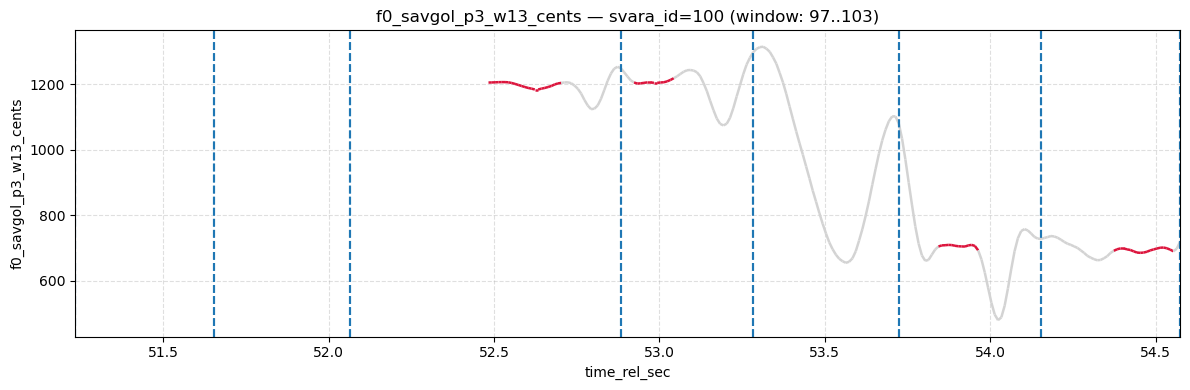

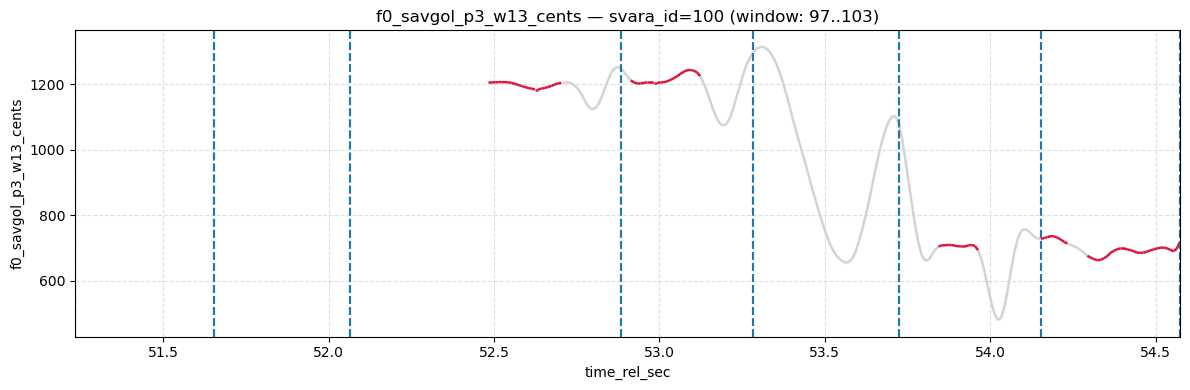

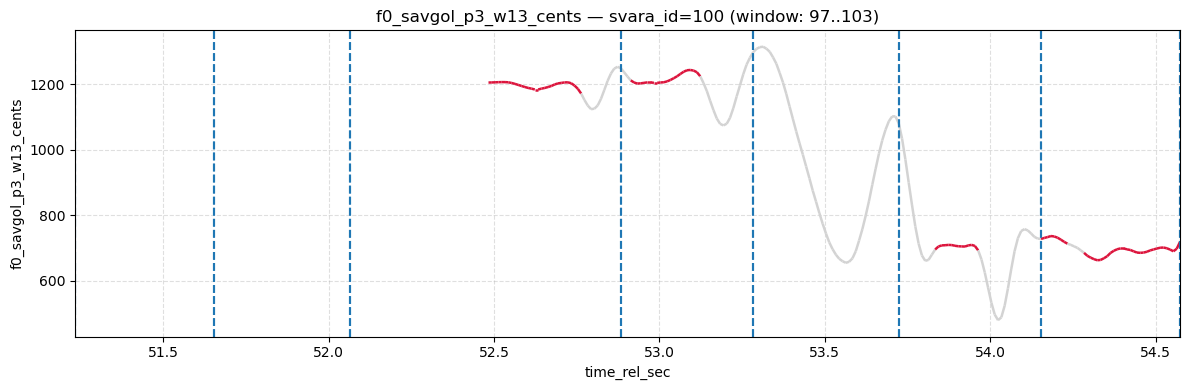

In [11]:
from src.utils.plot import plot_svara_window_with_flat_regions

t_min = float(df.select(pl.col(S.TIME_COL).min()).item())
t0 = t_min + 685.0
t1 = t0 + 10.0

TOLERANCE_CENTS = 10
D1_THRESHOLD_LIST = [500, 750, 1000]
TONIC = S.SARASUDA_TONICS[S.CURRENT_PIECE]
SVARA_ID=100

for D1_THRESHOLD in D1_THRESHOLD_LIST:
    
    df = load_preprocessed_pitch(
        recording_id=recording_id,
        root_dir=S.DATA_INTERIM,
        tonic_hz=TONIC,
        convert_to_cents=True,
    )
    df_svaras = load_annotations(
        file_path=ann_path,
        annotation_type="svara",

    )

    df = attach_svara_annotations_to_pitch(df, df_svaras) 
    
    df = extract_flat_regions(
        df,
        time_col=S.TIME_COL,
        pitch_col=pitch_col,
        pitch_unit="cents",
        candidate_col=S.CANDIDATE_COL,   # si no existeix, es crearà dins la funció
        out_col=S.STABLE_COL,
        min_duration_sec=S.MIN_STABLE_DURATION_SEC,
        cent_tolerance=TOLERANCE_CENTS,
        d1_threshold=D1_THRESHOLD,
        abs_deriv1_col=getattr(S, "ABS_DERIV1_COL", None),  # opcional per debug
        verbose=False,
    )

    fig, ax = plot_svara_window_with_flat_regions(
        df,
        svara_id=SVARA_ID,
        pitch_col="f0_savgol_p3_w13_cents",
        stable_col="flat_region",
        window_n=6,   # 2 veïns
    )




In [12]:
import polars as pl
import settings as S
from src.io.pitch_io import load_preprocessed_pitch
import matplotlib.pyplot as plt

recording_id = S.CURRENT_PIECE
tonic_hz = S.SARASUDA_TONICS[recording_id]

df_pitch = load_preprocessed_pitch(
    recording_id=recording_id,
    root_dir=S.DATA_INTERIM,
    tonic_hz=tonic_hz,
    convert_to_cents=True,
)

flat_path = S.DATA_INTERIM / recording_id / "flat_regions" / f"{recording_id}_flat_regions.parquet"
df_flat = pl.read_parquet(flat_path)

df_pitch.columns, df_flat.columns

(['time_rel_sec',
  'f0_Hz',
  'group_id',
  'f0_pchip',
  'f0_savgol_p3_w13',
  'f0_savgol_p3_w27',
  'f0_Hz_cents',
  'f0_pchip_cents',
  'f0_savgol_p3_w13_cents',
  'f0_savgol_p3_w27_cents'],
 ['f0_Hz',
  'f0_pchip',
  'f0_pchip_cents',
  'time_rel_sec',
  'f0_savgol_p3_w13',
  'f0_savgol_p3_w13_cents',
  'flat_candidate',
  'flat_region',
  'flat_id'])

In [13]:
from src.features.pitch_distribution import theoretical_svarasthanas_cents, found_svarasthanas_from_kde, flat_region_svara_proportions, compute_pitch_distribution_peaks_df
from src.utils.plot_2 import add_flat_threshold_segments_to_ax, add_svarasthana_guides_to_ax
import numpy as np


grid_cents, density, peak_cents, peak_densities, df_kde_peaks = (
    compute_pitch_distribution_peaks_df(
        df_pitch,
        pitch_col="f0_savgol_p3_w13_cents",
        pitch_unit="cents",   # o "hz"
        tonic_hz=tonic_hz,
        recording_id=recording_id,
    )
)
theo = theoretical_svarasthanas_cents(raga="saveri", with_octaves=True)

df_found_kde = found_svarasthanas_from_kde(df_kde_peaks, theoretical_cents=theo, n_largest=5, threshold_cents=30)
found_kde_cents = df_found_kde.select("svara_cents").unique().to_series().to_numpy()


In [14]:
df_hits, df_props = flat_region_svara_proportions(
    df_pitch=df_flat,
    pitch_cents_col="f0_savgol_p3_w13_cents",
    theoretical_cents=theo,
    threshold_cents=30,
)
found_flat_cents = df_hits.select("svara_cents").unique().to_series().to_numpy()

In [16]:
SVARA_ID=5


/tmp/ipykernel_11460/815312705.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


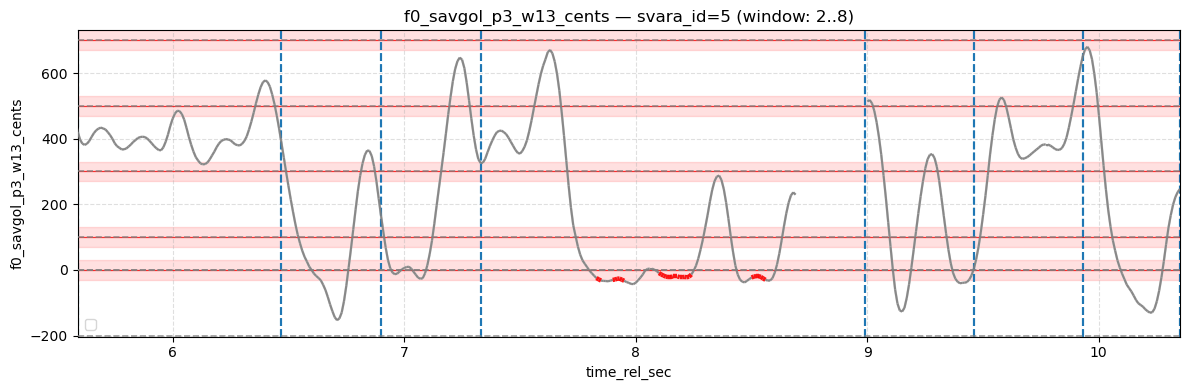

/tmp/ipykernel_11460/815312705.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


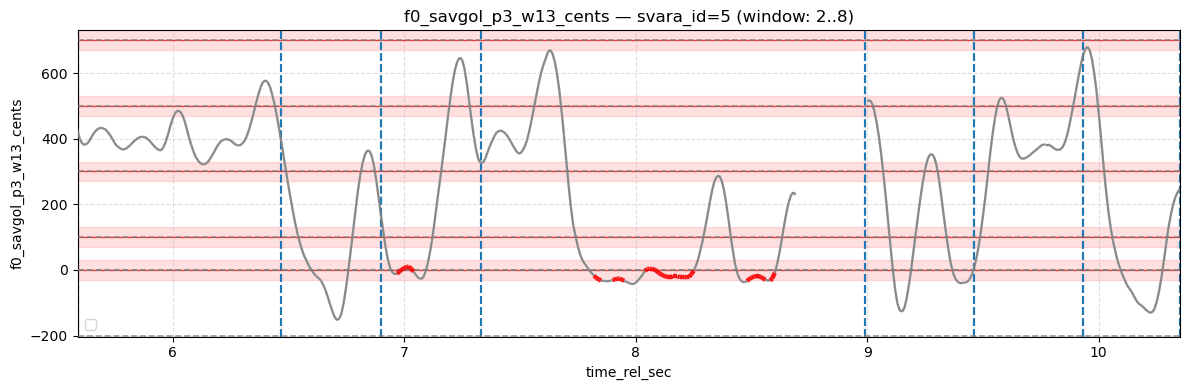

/tmp/ipykernel_11460/815312705.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


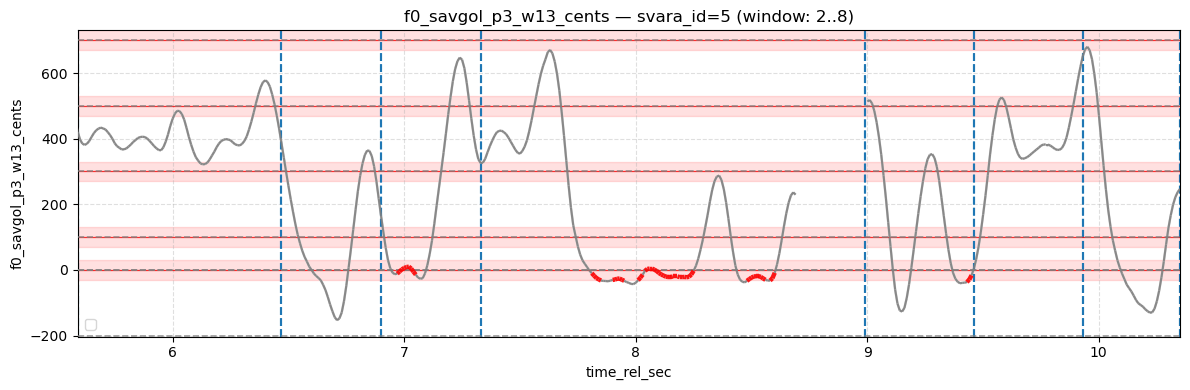

In [17]:
for D1_THRESHOLD in D1_THRESHOLD_LIST:
    
    df = load_preprocessed_pitch(
        recording_id=recording_id,
        root_dir=S.DATA_INTERIM,
        tonic_hz=TONIC,
        convert_to_cents=True,
    )
    df_svaras = load_annotations(
        file_path=ann_path,
        annotation_type="svara",

    )

    df = attach_svara_annotations_to_pitch(df, df_svaras) 
    
    df_flat = extract_flat_regions(
        df,
        time_col=S.TIME_COL,
        pitch_col=pitch_col,
        pitch_unit="cents",
        candidate_col=S.CANDIDATE_COL,   # si no existeix, es crearà dins la funció
        out_col=S.STABLE_COL,
        min_duration_sec=S.MIN_STABLE_DURATION_SEC,
        cent_tolerance=TOLERANCE_CENTS,
        d1_threshold=D1_THRESHOLD,
        abs_deriv1_col=getattr(S, "ABS_DERIV1_COL", None),  # opcional per debug
        verbose=False,
    )

    fig, ax = plot_svara_window_with_flat_regions(
    df,
    svara_id=SVARA_ID,
    pitch_col="f0_savgol_p3_w13_cents",
    stable_col="flat_region",
    window_n=6,
    )

    # filtra a rang visible
    y0, y1 = ax.get_ylim()
    found_in = np.unique(np.concatenate([found_kde_cents, found_flat_cents]))
    found_in = found_in[(found_in >= y0) & (found_in <= y1)]
    theo_in = theo[(theo >= y0) & (theo <= y1)]

    add_svarasthana_guides_to_ax(
        ax,
        theoretical_cents=theo_in,
        found_cents=found_in,
        threshold_cents=30,
        show_theoretical=True,
        show_found=True,
        show_band=True,
    )

    add_flat_threshold_segments_to_ax(
        ax,
        df_pitch=df_flat,  # <-- important
        pitch_cents_col="f0_savgol_p3_w13_cents",
        theoretical_cents=theo,
        threshold_cents=30,
    )

    ax.legend()
    plt.show()
